Model is single hidden layer: x -> n_h -> y  (size of x and y is equal)

W1 = (n_h, x), W2 = (y, n_h)
x = 3 features (should be able to vary this)
y = abs(x) 
n_h = 2 neurons (should be able to vary this)
loss = MSE

- Vary the activation function used in each layer (e.g. ReLU or identity, by default, ReLU)

- Vary the bias value used in each layer (all equal or specific values)

- Vary the feature sparsity (all equal or specific values (e.g. function of index))

- Vary the feature importance (all equal or specific values (e.g. function of index))

- Vary the loss fn

- Optional: Vary optimizer and lr schedule

In [21]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
@dataclass
class CisConfig:
    n_instances: int = 2
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    feat_sparsity: float| t.Tensor = 0
    feat_importance: float | t.Tensor = 1.0
    optimizer: Callable = t.optim.Adam

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [23]:
class Cis(nn.Module):
    """Computation in Superposition toy model."""

    # Some attribute type hints
    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]
    s: Float[t.Tensor, "inst feat"]  # feature sparsity
    i: Float[t.Tensor, "inst feat"]  # feature importance


    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))

        # Model Biases
        # self.b1 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden)) if cfg.b1 == "0" else cfg.b1
        self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden) if cfg.b1 == "0" else cfg.b1
        self.b2 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_feat)) if cfg.b2 == "0" else cfg.b2

        # Sparsities
        if isinstance(cfg.feat_sparsity, float):
            self.s = t.full((cfg.n_instances, cfg.n_feat), cfg.feat_sparsity)
        else:
            self.s = cfg.feat_sparsity

        # Importances
        if isinstance(self.cfg.feat_importance, float):
            self.i = t.full((self.cfg.n_feat,), self.cfg.feat_importance)
        elif callable(self.cfg.feat_importance):
            self.i = cfg.feat_importance(self.cfg.n_feat)
        
        print(f"importance : {self.i}")
            

    def gen_batch(self, batch_sz: int) -> Float[t.Tensor, "batch inst feat"]:
        """Generates a batch of data (sparse feature vals on [-1, 1])."""

        # Randomly generate features vals, and for each, randomly determine which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) * 2 - 1  # [-1, 1]
        is_active = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) < (1 - self.s)
        
        return x * is_active


    def forward(
        self, x: Float[t.Tensor, "batch inst feat"], fx: Callable = t.abs
    ) -> Float[t.Tensor, ""]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        y = self.cfg.act_fn[1](y + self.b2)

        # Compute weighted MSE loss
        y_true = fx(x)
        loss = reduce(((y - y_true) ** 2 * self.i), "batch inst feat -> ", "mean")

        return loss


    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            loss = self.forward(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        return losses

In [24]:
def discounting_importance(n_feat: int, base: float = 0.8) -> t.Tensor:
    exponents = t.arange(0, n_feat, dtype=t.float32)
    return t.pow(base, exponents)

In [43]:
n_instances=1
n_feat = 100
n_hidden = 40
feat_sparsity = 0.9
feat_importance = discounting_importance

config = CisConfig(n_instances=1, n_feat=n_feat, n_hidden=n_hidden, feat_sparsity=feat_sparsity, feat_importance=feat_importance)

In [44]:
model = Cis(config)

importance : tensor([1.0000e+00, 8.0000e-01, 6.4000e-01, 5.1200e-01, 4.0960e-01, 3.2768e-01,
        2.6214e-01, 2.0972e-01, 1.6777e-01, 1.3422e-01, 1.0737e-01, 8.5899e-02,
        6.8719e-02, 5.4976e-02, 4.3980e-02, 3.5184e-02, 2.8148e-02, 2.2518e-02,
        1.8014e-02, 1.4412e-02, 1.1529e-02, 9.2234e-03, 7.3787e-03, 5.9030e-03,
        4.7224e-03, 3.7779e-03, 3.0223e-03, 2.4179e-03, 1.9343e-03, 1.5474e-03,
        1.2379e-03, 9.9035e-04, 7.9228e-04, 6.3383e-04, 5.0706e-04, 4.0565e-04,
        3.2452e-04, 2.5961e-04, 2.0769e-04, 1.6615e-04, 1.3292e-04, 1.0634e-04,
        8.5071e-05, 6.8057e-05, 5.4445e-05, 4.3556e-05, 3.4845e-05, 2.7876e-05,
        2.2301e-05, 1.7841e-05, 1.4272e-05, 1.1418e-05, 9.1344e-06, 7.3075e-06,
        5.8460e-06, 4.6768e-06, 3.7414e-06, 2.9932e-06, 2.3945e-06, 1.9156e-06,
        1.5325e-06, 1.2260e-06, 9.8080e-07, 7.8464e-07, 6.2771e-07, 5.0217e-07,
        4.0173e-07, 3.2139e-07, 2.5711e-07, 2.0569e-07, 1.6455e-07, 1.3164e-07,
        1.0531e-07, 8.4250e

In [45]:
batch_sz = 128
steps = 5000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0015515232225880027,
 0.00031208476866595447,
 0.00027847415185533464,
 0.00020455155754461884,
 0.00010502215445740148,
 0.00010235736408503726,
 8.287111995741725e-05,
 9.025028703035787e-05,
 7.682749856030568e-05,
 7.334726251428947e-05,
 6.24990279902704e-05]

C:\Users\gigle\AppData\Local\Temp\ipykernel_55996\213167100.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


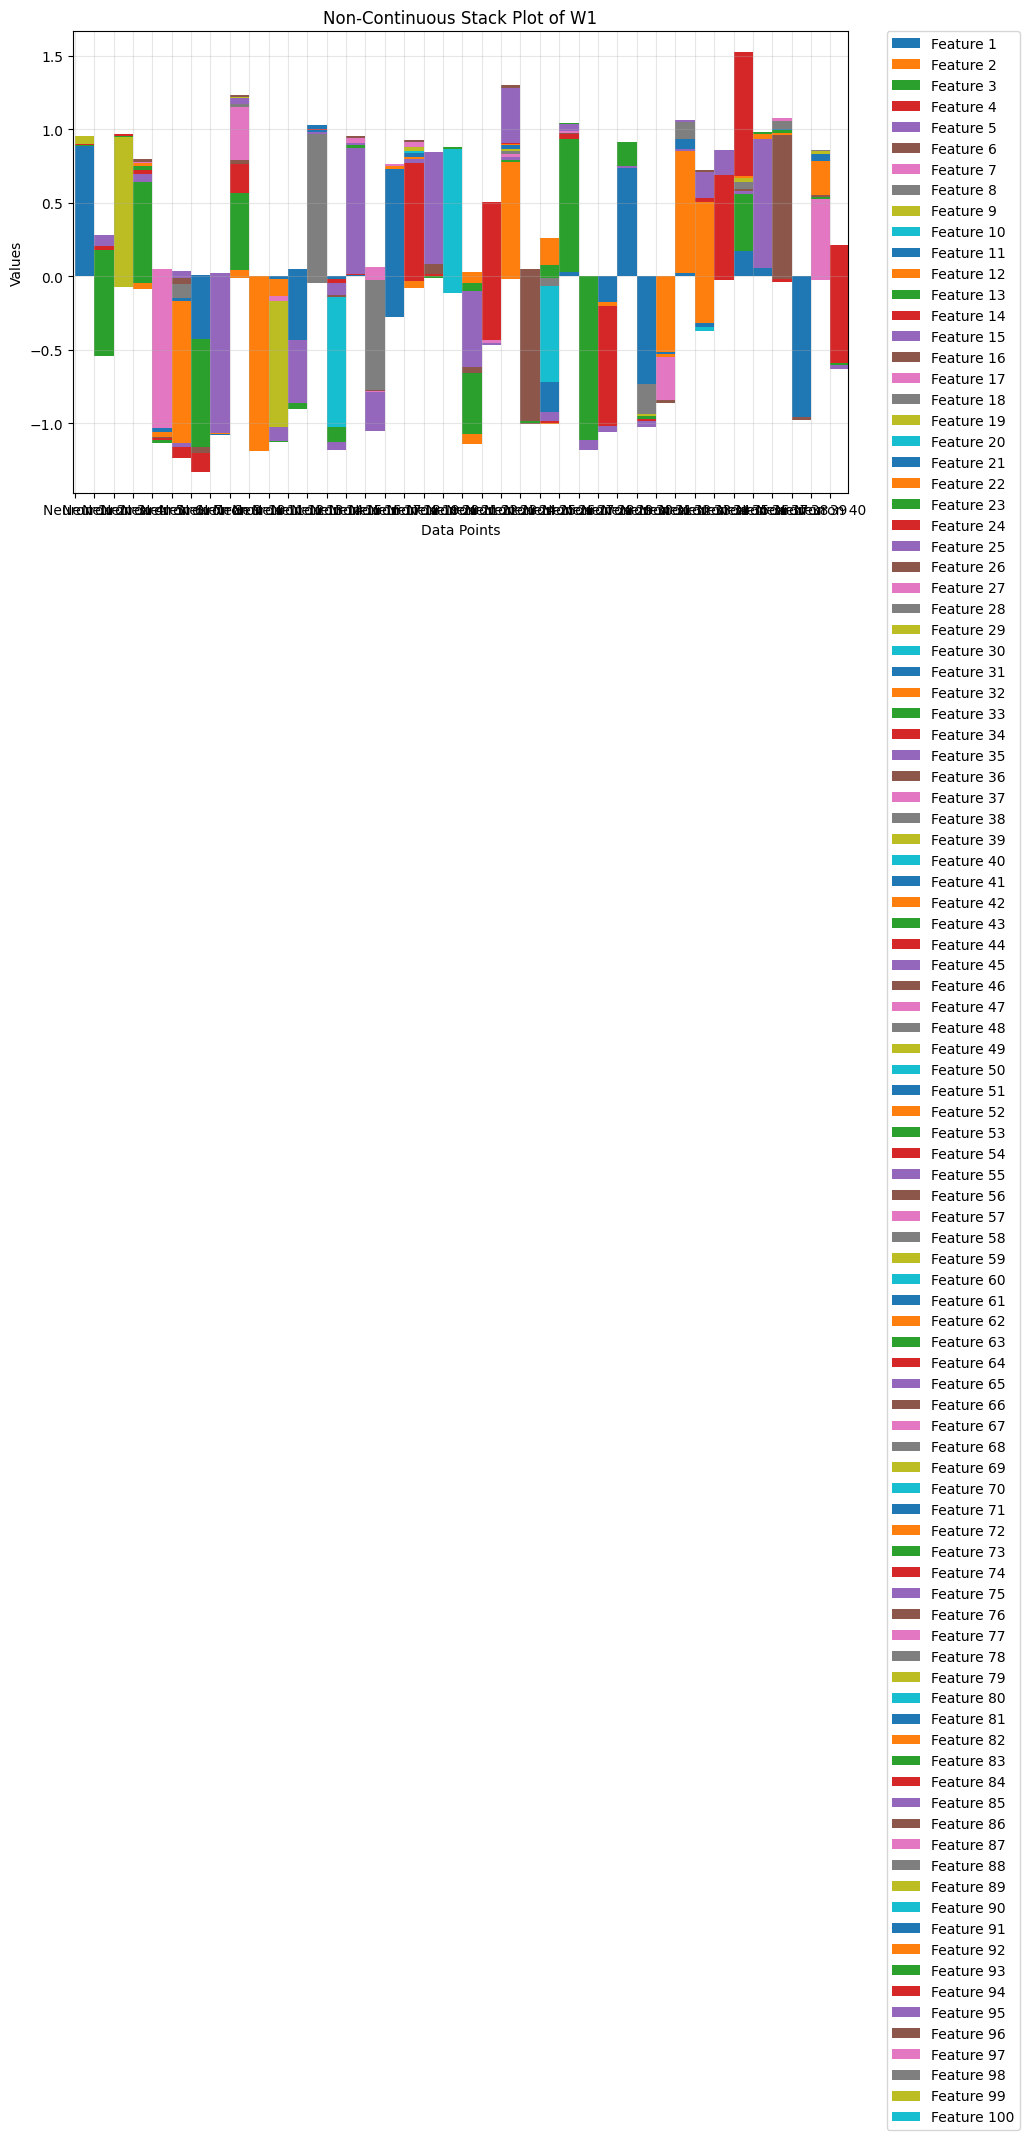

In [46]:
plot_polysemanticity(model.W1.detach().squeeze())

In [102]:
model.W1

Parameter containing:
tensor([[[ 1.0469, -0.0106, -0.8279, -0.0021, -0.0026, -0.0107],
         [-0.0100, -0.0017, -0.0079, -1.1026,  1.3598, -0.0017],
         [ 0.0028,  1.1591,  0.0022,  0.0217,  0.0267, -1.1735]]],
       requires_grad=True)

In [103]:
model.W2

Parameter containing:
tensor([[[ 9.5527e-01,  1.7602e-03,  8.7130e-03],
         [-2.2676e-03, -1.7184e-02,  8.6281e-01],
         [ 1.2080e+00, -2.2295e-03, -1.1111e-02],
         [-8.7021e-03,  9.0732e-01, -1.3165e-03],
         [ 7.0212e-03,  7.3574e-01,  1.0730e-03],
         [ 2.2604e-03,  1.6757e-02,  8.5224e-01]]], requires_grad=True)

In [68]:
model.b1

Parameter containing:
tensor([[-1.1866e-04,  5.7883e-01, -1.6888e-02, -1.4789e-02]],
       requires_grad=True)

In [69]:
model.b2

Parameter containing:
tensor([[0.9745, 0.0626]], requires_grad=True)

In [73]:
print("Model parameters:", [name for name, _ in model.named_parameters()])

Model parameters: ['W1', 'W2', 'b2']


In [27]:
def plot_polysemanticity(W1):
    import matplotlib.pyplot as plt

    # Define the weight matrix
    #W1 = model.W1.detach().numpy().squeeze()
    W1 = threshold_matrix(W1)

    # Create feature labels
    features = [f'Feature {i+1}' for i in range(W1.shape[0])]

    # Extend x range by one point to show the last step
    x = np.arange(W1.shape[1] + 1)
    # Extend the weight matrix data by repeating the last column
    W1_extended = np.hstack([W1, W1[:, -1:]])

    # Create larger figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create stack plot with extended data
    ax.stackplot(x, W1_extended, labels=features, step='post')
    ax.set_xlim(-0.1, W1.shape[1] - 0.1)  # Set limit to show exactly 6 stacks

    # Enhance visibility
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Set titles and labels
    ax.set_title('Non-Continuous Stack Plot of W1')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')

    # Add x-ticks for each neuron
    ax.set_xticks(np.arange(W1.shape[1]))
    ax.set_xticklabels([f'Neuron {i+1}' for i in range(W1.shape[1])])

    # Adjust layout to prevent cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

In [29]:
def threshold_matrix(matrix, threshold=0.01):
    """
    Sets matrix elements to zero if their absolute value is below the threshold.
    
    Args:
        matrix: Input numpy array
        threshold: Values below this threshold will be set to 0 (default: 1e-10)
    
    Returns:
        numpy array with small values set to zero
    """
    # Create a copy to avoid modifying the original matrix
    result = np.copy(matrix)
    
    # Set elements below threshold to zero
    result[np.abs(result) < threshold] = 0
    
    return result